In [1]:
# !pip install torchange

In [2]:
import torchange
import geoai
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from geoai.change_detection import ChangeDetection
from IPython.display import Image

/opt/homebrew/Caskroom/miniconda/base/envs/geo/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/geo/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. Th

In [3]:
from libs.utils import get_device, visualize_comparison
device = get_device()

from libs.ee import initialize_ee
ee = initialize_ee(get_ipython())

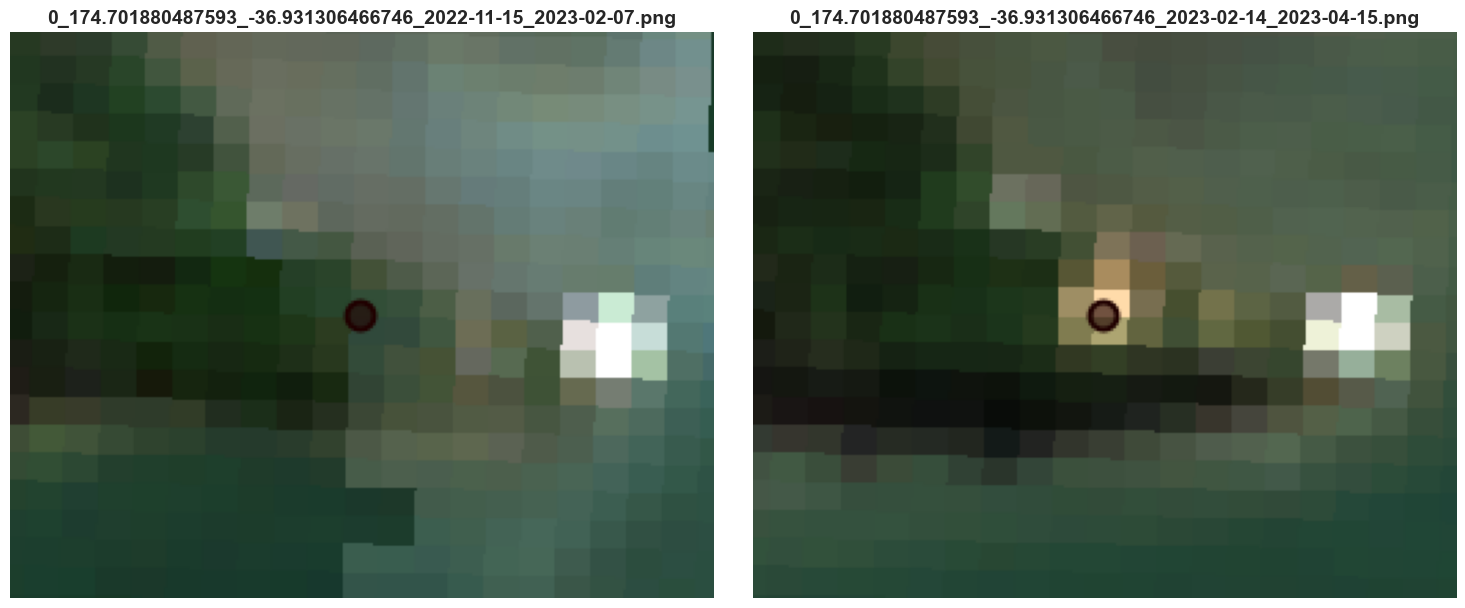

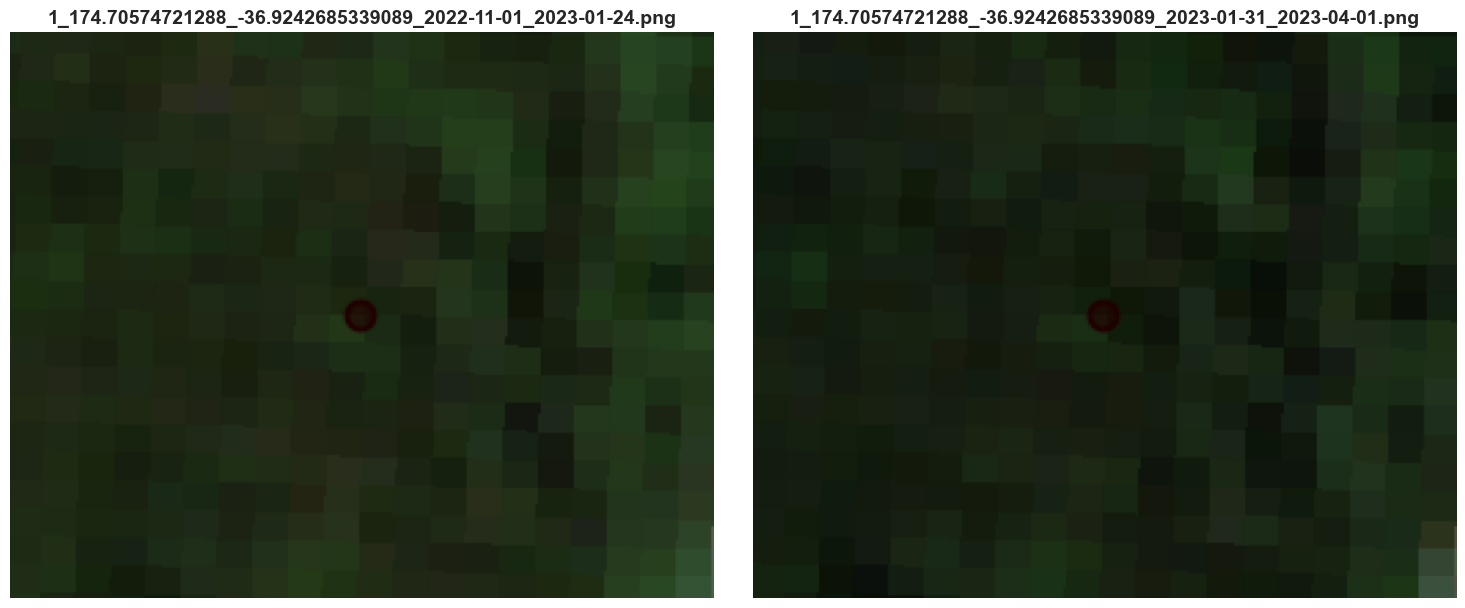

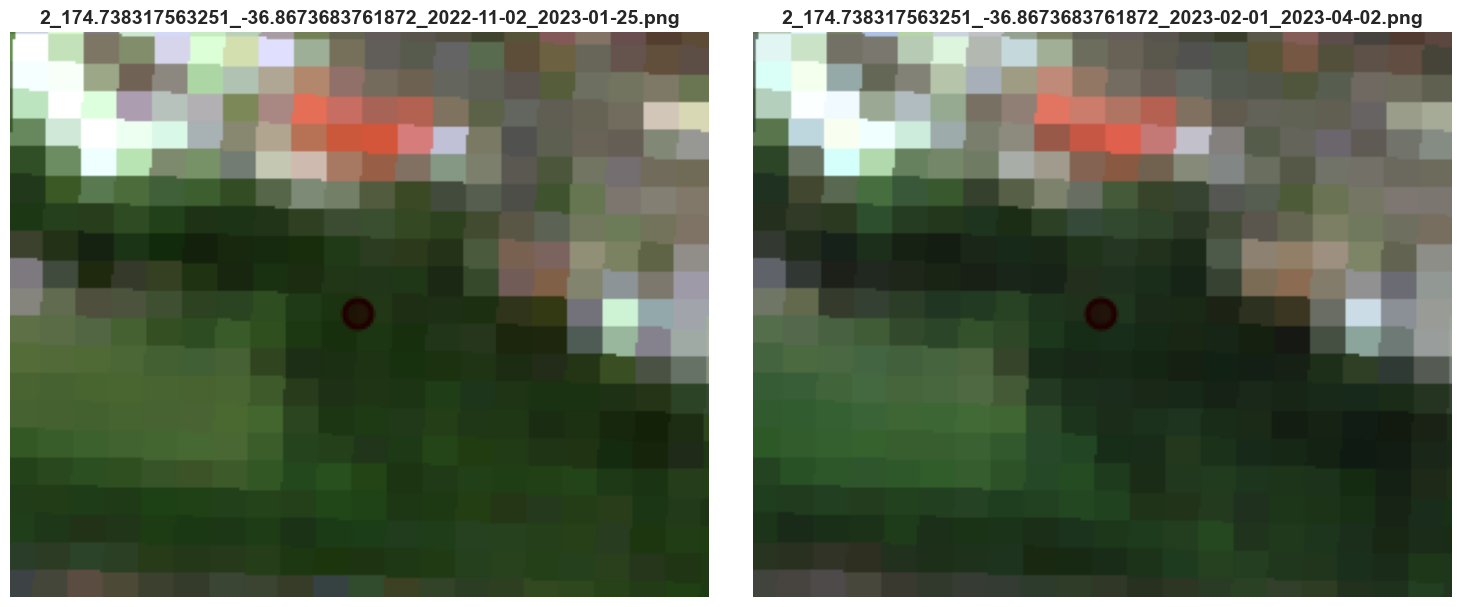

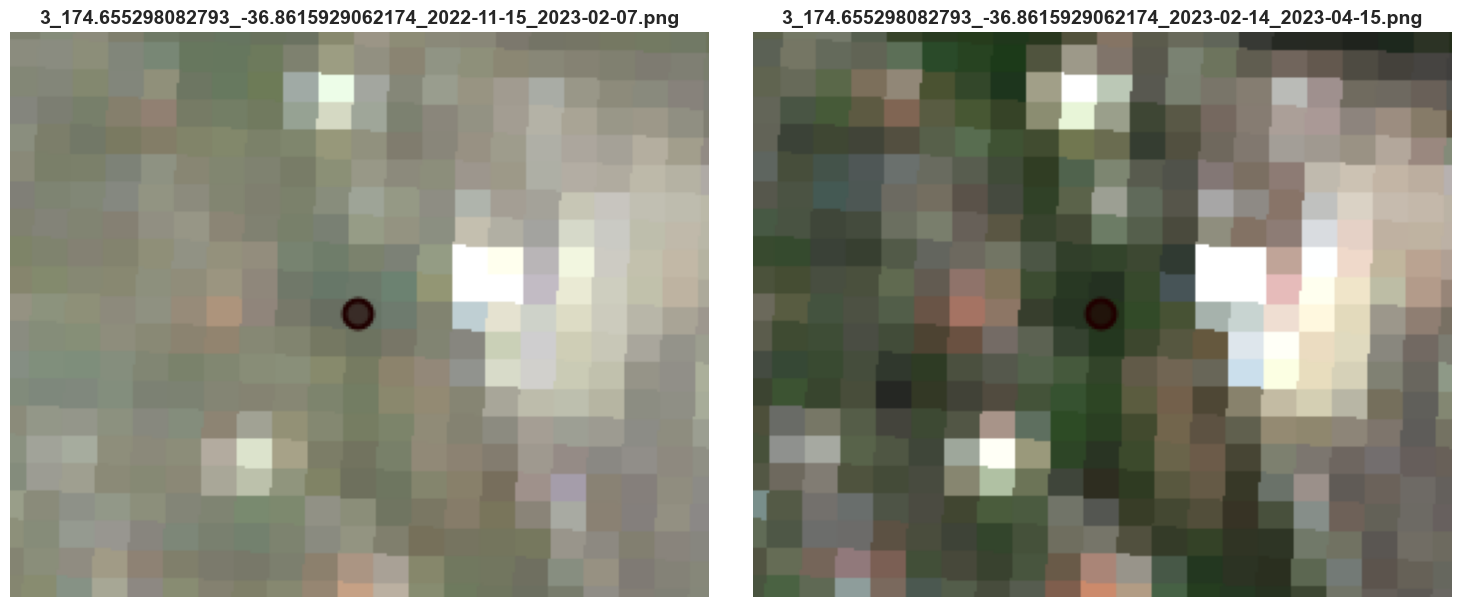

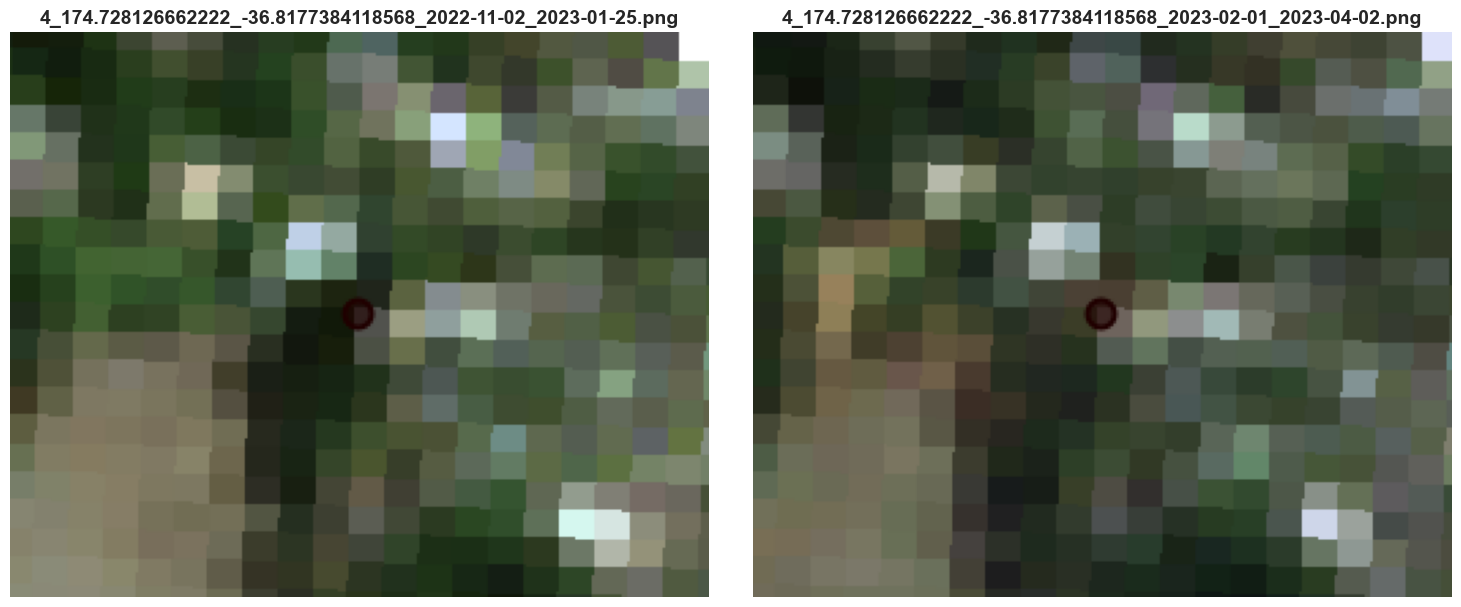

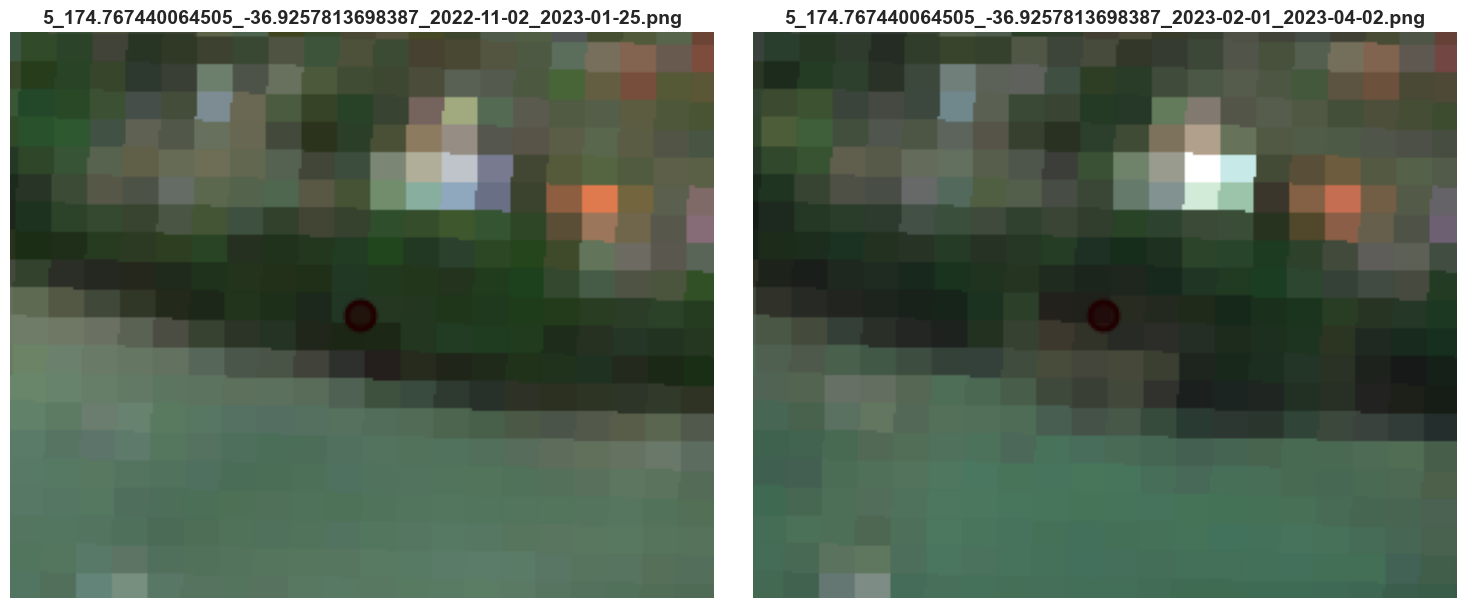

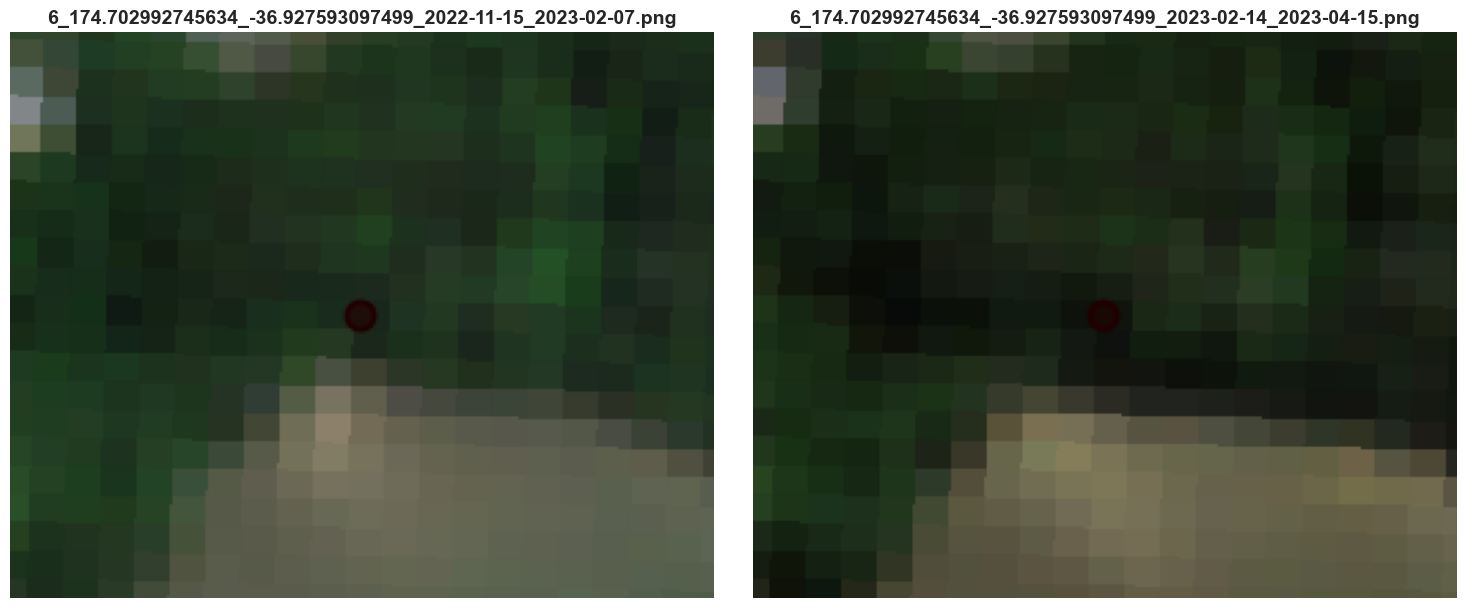

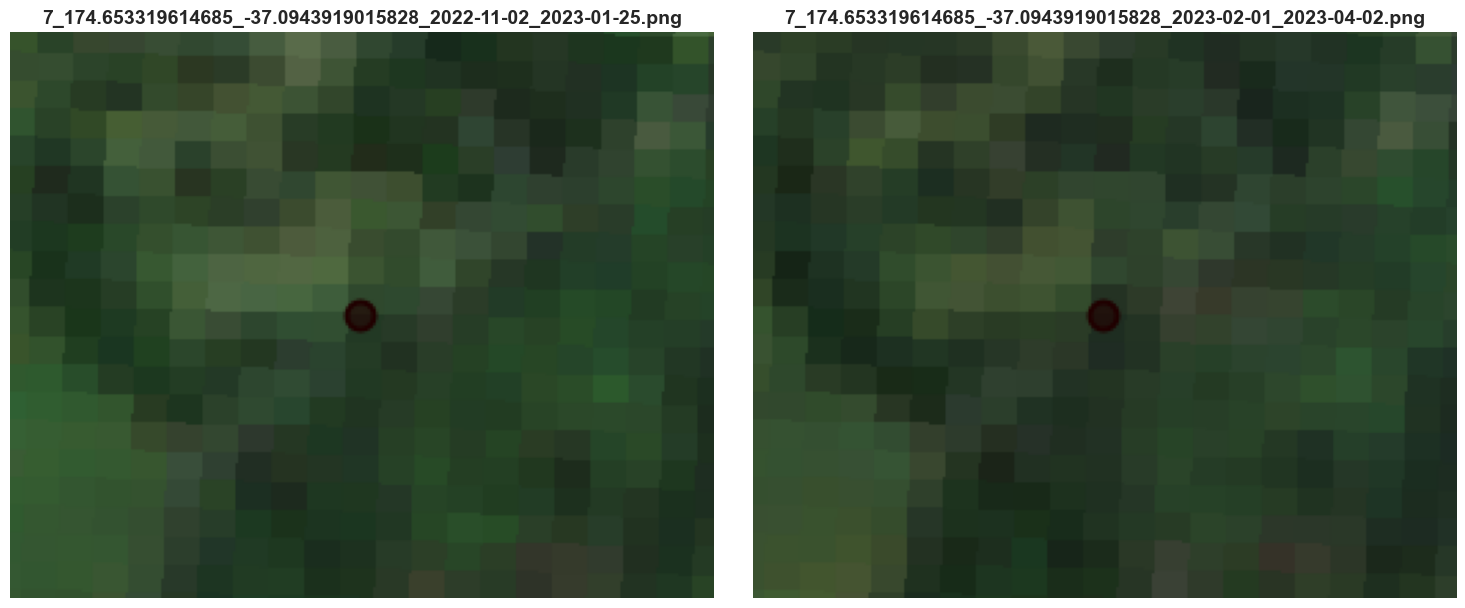

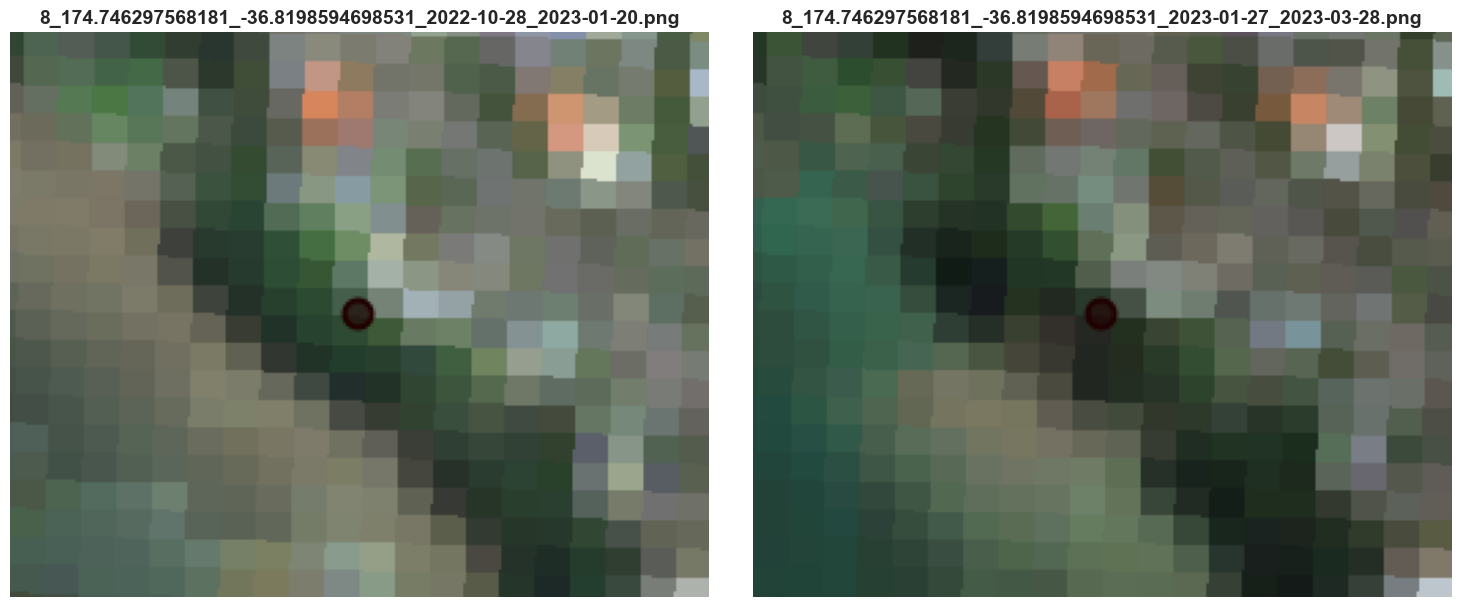

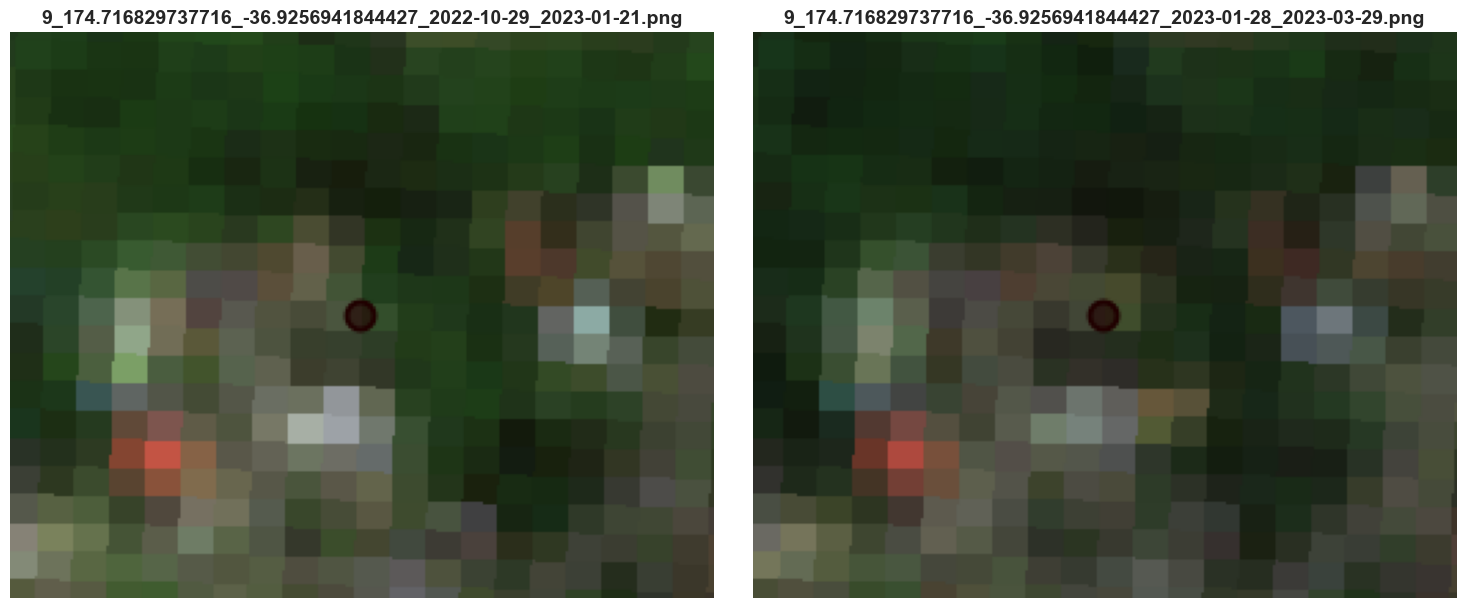

In [4]:
pre_dir_marks = "./data/4_change_detection/marks"
post_dir_marks = "./data/2-data-explore-events/marks"

# get list of images in pre_dir
pre_img_marks = [file for file in os.listdir(pre_dir_marks)]
post_img_marks = [file for file in os.listdir(post_dir_marks)]

pre_img_marks.sort()
post_img_marks.sort()

for idx, img_name in enumerate(pre_img_marks[:10]):
    pre_image_path = f"{pre_dir_marks}/{img_name}"
    post_image_path = f"{post_dir_marks}/{post_img_marks[idx]}"

    visualize_comparison(pre_image_path, post_image_path, left_title=img_name, right_title=post_img_marks[idx])

In [5]:
pre_dir = "./data/4_change_detection/rgb"
post_dir = "./data/2-data-explore-events/rgb"

# get list of images in pre_dir
pre_imgs = [file for file in os.listdir(pre_dir)]
post_imgs = [file for file in os.listdir(post_dir)]

In [7]:
idx = 0

pre_dir_rgb = "./data/4_change_detection/rgb"
post_dir_rgb = "./data/2-data-explore-events/rgb"

pre_rgb_files = sorted([f for f in os.listdir(pre_dir_rgb) if f.endswith('.png')])
post_rgb_files = sorted([f for f in os.listdir(post_dir_rgb) if f.endswith('.png')])

test_pre_img = f"{pre_dir_rgb}/{pre_rgb_files[idx]}"
test_post_img = f"{post_dir_rgb}/{post_rgb_files[idx]}"

pre_rgb_files[idx], post_rgb_files[idx]

('0_174.701880487593_-36.931306466746_2022-11-15_2023-02-07.png',
 '0_174.701880487593_-36.931306466746_2023-02-14_2023-04-15.png')

In [8]:
out_folder = "./data/5-change_detection/detection_results"
Path(out_folder).mkdir(exist_ok=True, parents=True)

print(f"Working directory: {out_folder}")

Working directory: ./data/5-change_detection/detection_results


In [9]:
# Make sure model directory exists
# to store downloaded model weights
Path("~/.cache/torch/hub/checkpoints/").expanduser().mkdir(parents=True, exist_ok=True)

# Initialize change detection
detector = ChangeDetection(sam_model_type="vit_h")

# Configure parameters (following the torchange example)
detector.set_hyperparameters(
    change_confidence_threshold=145,
    use_normalized_feature=True,
    bitemporal_match=True,
)

detector.set_mask_generator_params(
    points_per_side=32,
    stability_score_thresh=0.95,
)

print("Change detection system initialized!")

Change detection system initialized!


In [16]:
# Check AnyChange class signature
from torchange.models.segment_any_change import AnyChange
import inspect

print("AnyChange signature:")
print(inspect.signature(AnyChange.__init__))

AnyChange signature:
(self, model_type='vit_b', sam_checkpoint='./sam_weights/sam_vit_b_01ec64.pth')


In [18]:
# Since the images are PNG without geospatial metadata, we need to convert them to GeoTIFF
# with dummy geospatial information so the geoai library can process them

import rasterio
from rasterio.transform import from_bounds
from PIL import Image as PILImage
import numpy as np

# Load PNG images
img1 = np.array(PILImage.open(test_pre_img))
img2 = np.array(PILImage.open(test_post_img))

print(f"Image 1 shape: {img1.shape}")
print(f"Image 2 shape: {img2.shape}")

# Create temporary GeoTIFF files with dummy geospatial information
temp_pre_tif = f"{out_folder}/temp_pre.tif"
temp_post_tif = f"{out_folder}/temp_post.tif"

# Define dummy bounds (same for both images so they overlap perfectly)
height, width = img1.shape[:2]
bounds = (0, 0, width, height)  # left, bottom, right, top
transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)

# Write pre-event image as GeoTIFF
with rasterio.open(
    temp_pre_tif, 'w',
    driver='GTiff',
    height=height,
    width=width,
    count=3,
    dtype=img1.dtype,
    crs='EPSG:4326',  # Dummy CRS
    transform=transform
) as dst:
    for i in range(3):
        dst.write(img1[:, :, i], i + 1)

# Write post-event image as GeoTIFF
with rasterio.open(
    temp_post_tif, 'w',
    driver='GTiff',
    height=height,
    width=width,
    count=3,
    dtype=img2.dtype,
    crs='EPSG:4326',  # Dummy CRS
    transform=transform
) as dst:
    for i in range(3):
        dst.write(img2[:, :, i], i + 1)

print(f"\nTemporary GeoTIFF files created")

# Now run change detection with the GeoTIFF files
results = detector.detect_changes(
    temp_pre_tif,
    temp_post_tif,
    output_path=f"{out_folder}/binary_mask.tif",
    export_probability=True,
    probability_output_path=f"{out_folder}/probability_mask.tif",
    export_instance_masks=True,
    instance_masks_output_path=f"{out_folder}/instance_masks.tif",
    return_detailed_results=True,
    return_results=False,
)

print(f"\nChange detection completed!")
print(f"Total instances detected: {results['summary']['total_masks']}")
print(f"Image size: {results['summary']['original_shape']}")

Image 1 shape: (206, 256, 3)
Image 2 shape: (206, 256, 3)

Temporary GeoTIFF files created
Saved instance segmentation mask with 23 instances to ./data/5-change_detection/detection_results/instance_masks.tif
Saved instance scores mask with 23 instances to ./data/5-change_detection/detection_results/instance_masks_scores.tif

Change detection completed!
Total instances detected: 23
Image size: (206, 256)
Saved instance segmentation mask with 23 instances to ./data/5-change_detection/detection_results/instance_masks.tif
Saved instance scores mask with 23 instances to ./data/5-change_detection/detection_results/instance_masks_scores.tif

Change detection completed!
Total instances detected: 23
Image size: (206, 256)


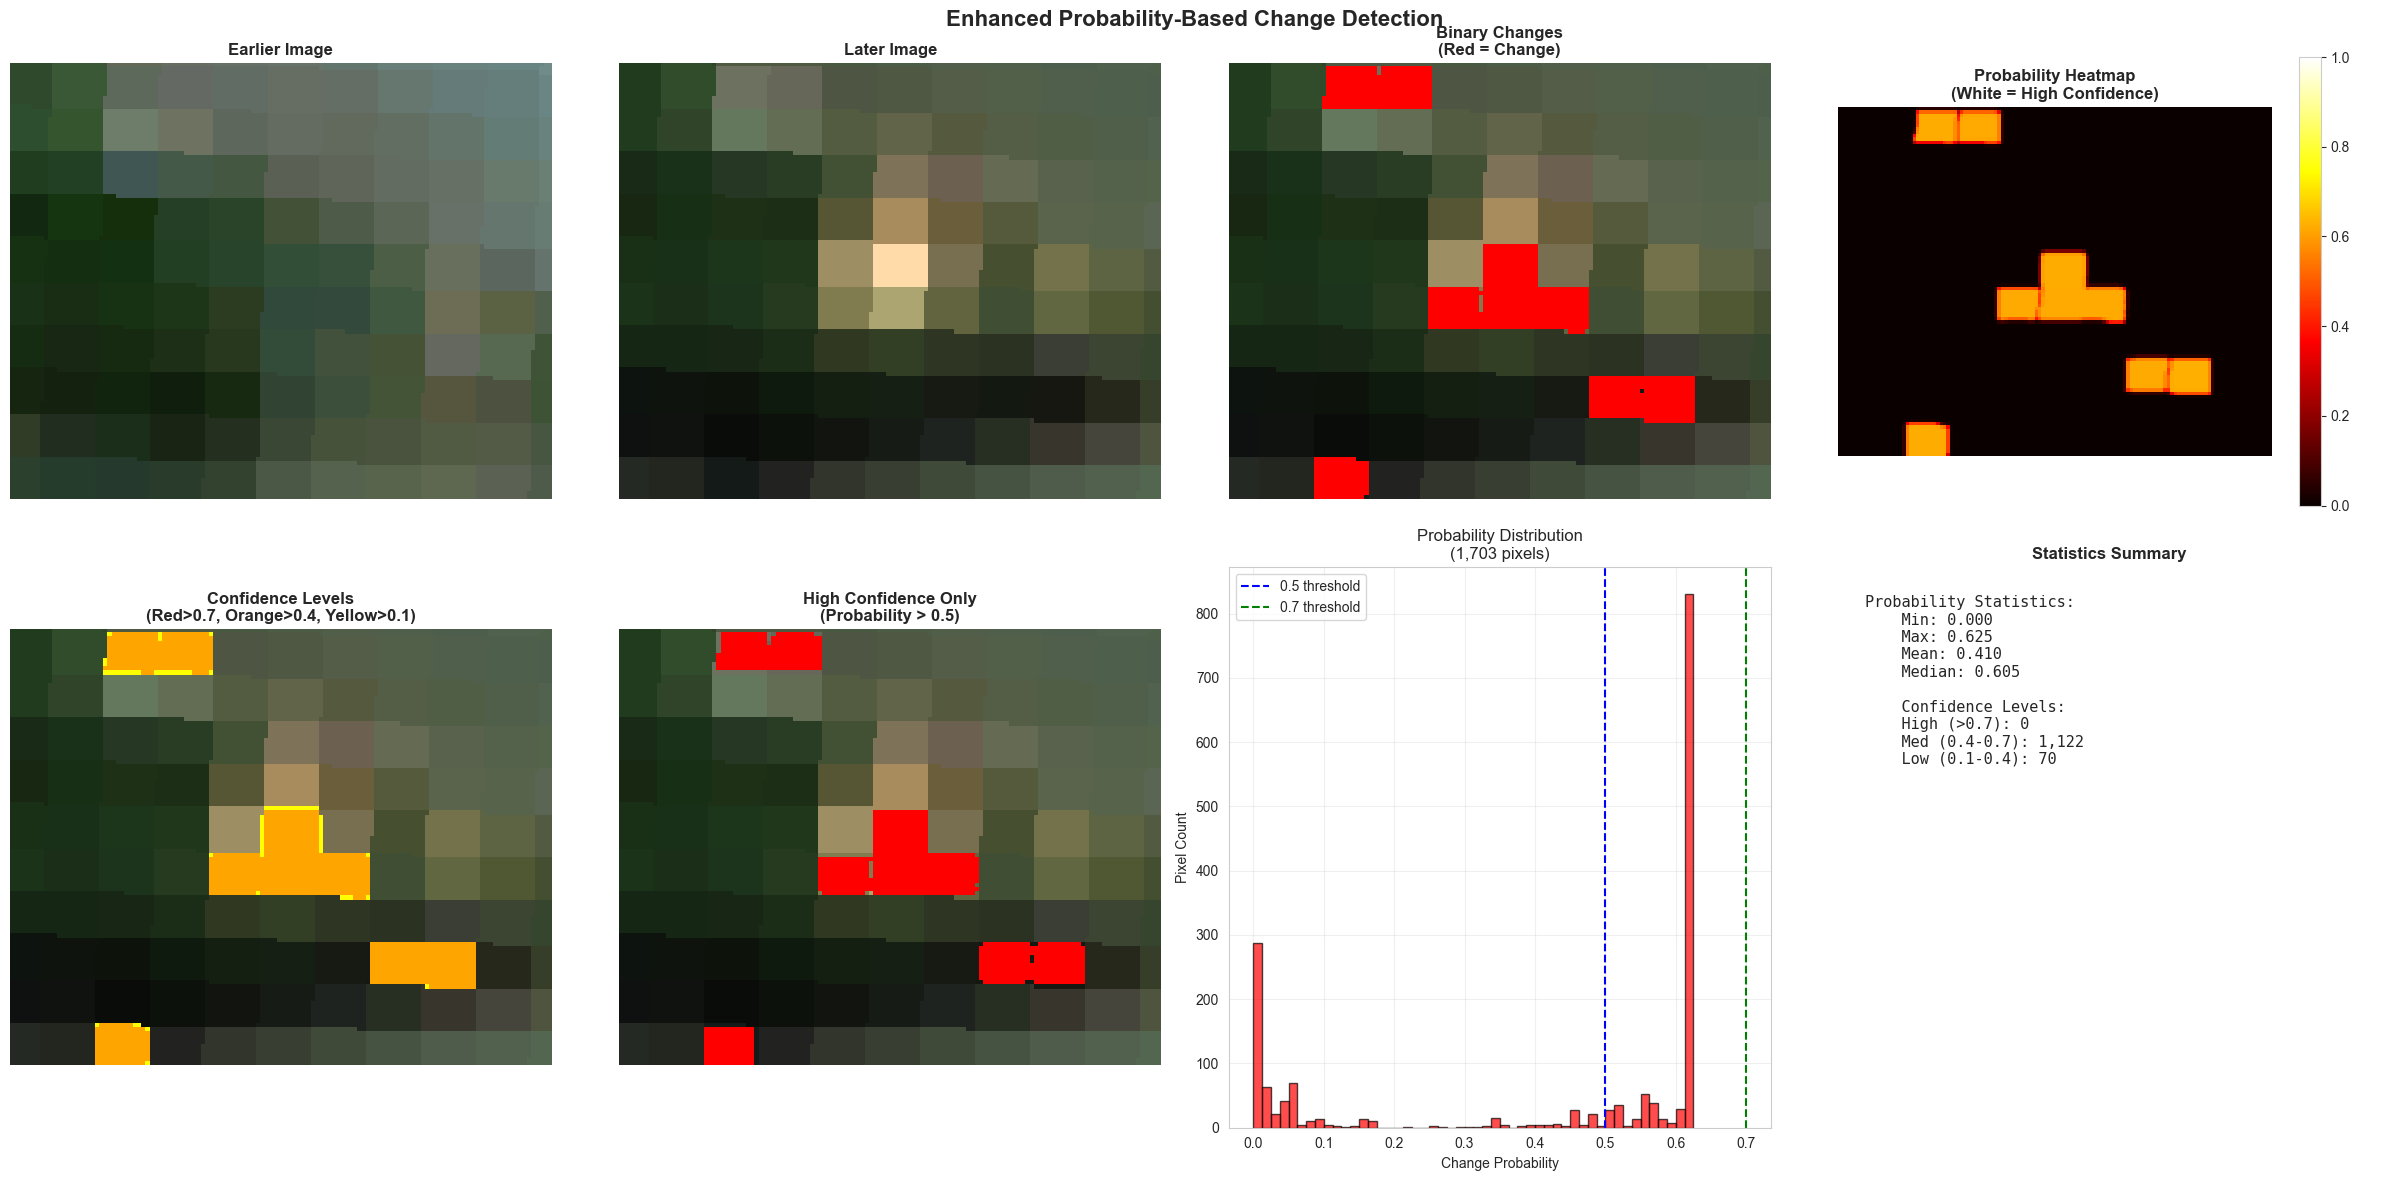

💾 Enhanced visualization saved as 'enhanced_probability_results.png'


In [19]:
# probability visualization
detector.visualize_results(
    test_pre_img,
    test_post_img,
    f"{out_folder}/binary_mask.tif",
    f"{out_folder}/probability_mask.tif",
)